In [1]:
import time
from typing import Any

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# Exclusion list and column definitions
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

In [3]:
def define_numeric_column(data: pd.DataFrame) -> list[Any]:
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]

def print_score(y_test, y_test_pred, training_time, train_accuracy, test_accuracy):
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"SIMPLE DECISION TREE with Hyperparameter Tuning")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Decision Tree Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y)
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))

def check_fitting(train_accuracy, test_accuracy):
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")

def preprocess_data(data: pd.DataFrame) -> tuple:
    try:
        data = data.copy()
        data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
        numeric = define_numeric_column(data)
        return data[nominal + numeric + binary], data['attack_category']
    except Exception as e:
        raise ValueError(f"Error in preprocessing: {str(e)}")

def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

In [4]:
# Load and preprocess data
df = pd.read_csv('./data/kdd_merged.csv')
X, y = preprocess_data(df)
label_encode_nominal_data(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Hyperparameter Tuning ---
param_grid = {
    'max_depth': [5, 10, 15, 20, None],           # this Limit tree depth
    'min_samples_split': [2, 5, 10],              # sets min samples to split a node
    'min_samples_leaf': [1, 2, 5]                 # sets min samples per leaf
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

# Best model from grid search
best_dt = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)
print(f"Hyperparameter Tuning Time: {tuning_time:.4f} seconds")

# --- Feature Selection ---
selector = SelectKBest(score_func=f_classif, k='all')  # Start with all features
selector.fit(X_train, y_train)

# Get feature scores and select top features
feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print("\nFeature Importance Scores (ANOVA F-value):")
print(feature_scores)

k_values = [10, 20, 30]
best_k = 0
best_f1 = 0
best_X_train_selected = None
best_X_test_selected = None

for k in k_values:
    top_features = feature_scores['Feature'].head(k).tolist()
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    start_time = time.time()
    best_dt.fit(X_train_selected, y_train)
    training_time = time.time() - start_time

    y_train_pred = best_dt.predict(X_train_selected)
    y_test_pred = best_dt.predict(X_test_selected)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_k = k
        best_X_train_selected = X_train_selected
        best_X_test_selected = X_test_selected

# Final training with best features and hyperparameters
start_time = time.time()
best_dt.fit(best_X_train_selected, y_train)
training_time = time.time() - start_time

y_train_pred = best_dt.predict(best_X_train_selected)
y_test_pred = best_dt.predict(best_X_test_selected)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results with best configuration
print(f"\nBest Feature Configuration: Top {best_k} features")
print("Selected Features:", best_X_train_selected.columns.tolist())
print_score(y_test, y_test_pred, training_time, train_accuracy, test_accuracy)
check_fitting(train_accuracy, test_accuracy)

Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Hyperparameter Tuning Time: 87.9240 seconds

Feature Importance Scores (ANOVA F-value):
                        Feature         Score
21                same_srv_rate  51100.207067
31     dst_host_srv_serror_rate  35825.103424
30         dst_host_serror_rate  34903.917186
17                  serror_rate  34793.008345
18              srv_serror_rate  34604.460887
26       dst_host_same_srv_rate  28532.118971
25           dst_host_srv_count  28164.950398
35                    logged_in  26703.287248
2                          flag  24131.394544
15                        count  16409.415893
27       dst_host_diff_srv_rate  12605.496264
28  dst_host_same_src_port_rate   9037.228013
24               dst_host_count   8364.706192
22                diff_srv_rate   6724.228058
29  dst_host_srv_diff_host_rate   6249.386537
33     dst_host_srv_rerror

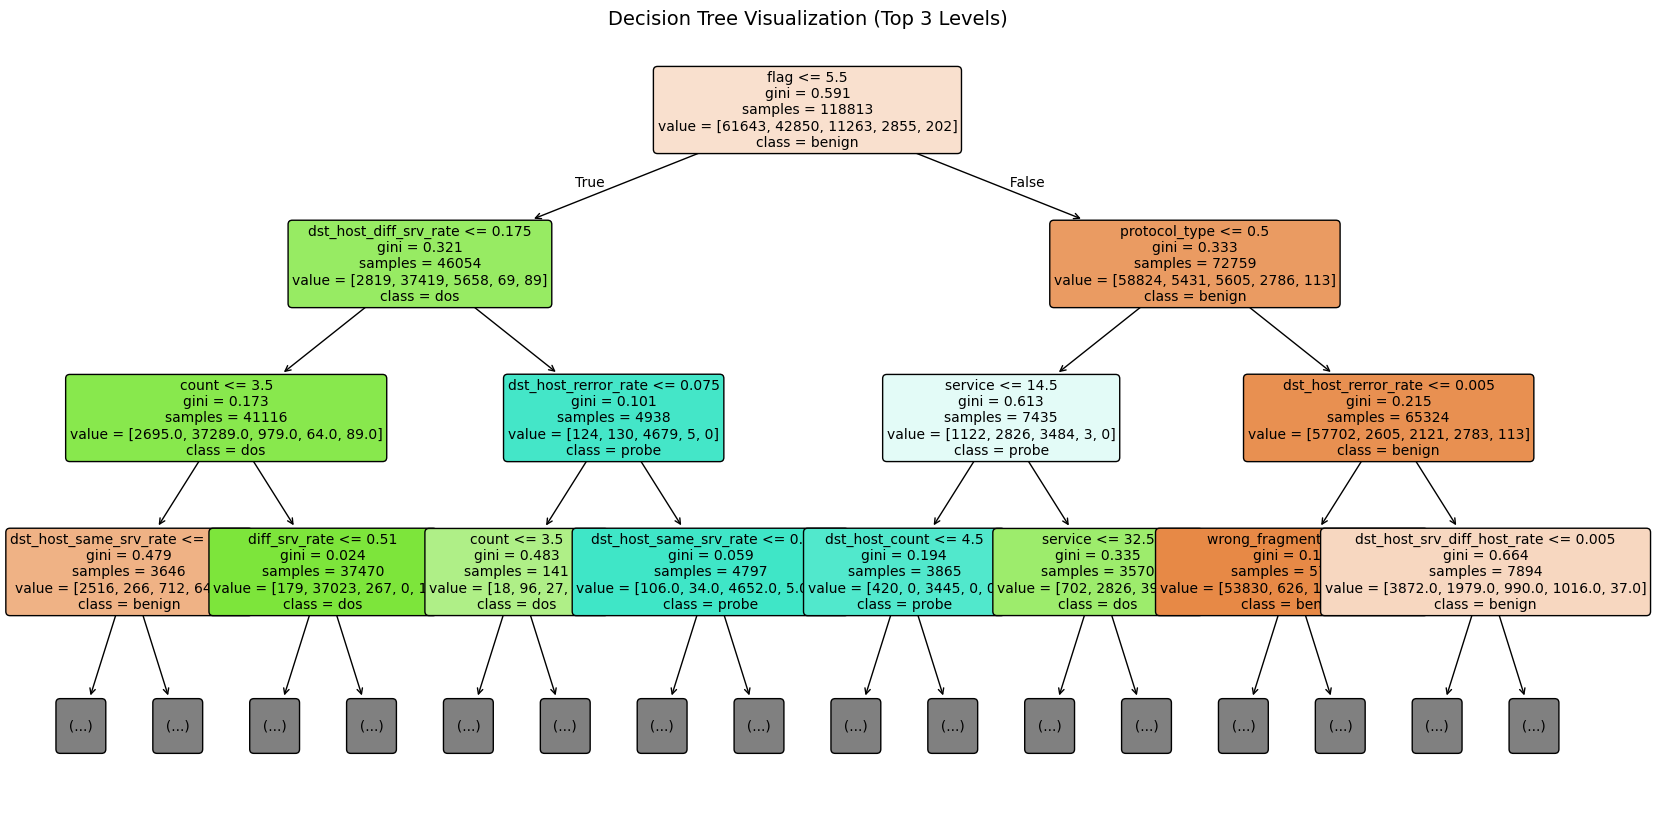

In [5]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# --- Visualize the Decision Tree ---
plt.figure(figsize=(20, 10))  # Adjust size for readability
plot_tree(best_dt,
          feature_names=best_X_train_selected.columns.tolist(),  # Use selected features
          class_names=np.unique(y).tolist(),                     # Unique attack categories
          filled=True,                                           # Color by class
          rounded=True,                                          # Rounded boxes
          fontsize=10,                                           # Font size
          max_depth=3)                                           # Limit depth for clarity
plt.title("Decision Tree Visualization (Top 3 Levels)", fontsize=14)
plt.show()

ROC Curve of this Model:

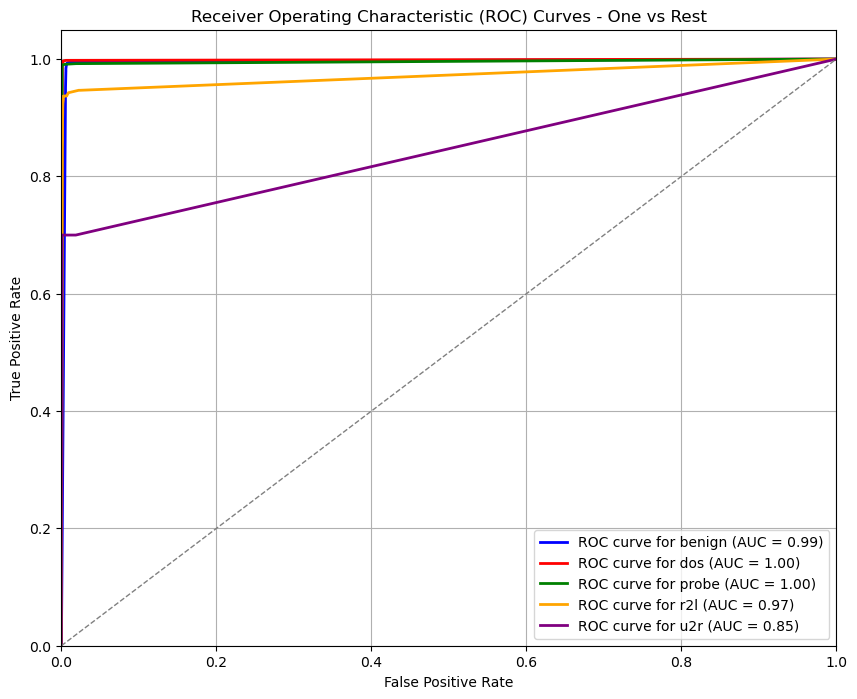


ROC AUC Scores for Each Class:
benign: 0.9949
dos: 0.9982
probe: 0.9956
r2l: 0.9720
u2r: 0.8471


In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get unique classes
classes = np.unique(y)
n_classes = len(classes)

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_test_prob = best_dt.predict_proba(best_X_test_selected)

# Compute ROC curve and ROC AUC for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust based on number of classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random guessing)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves - One vs Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores for each class
print("\nROC AUC Scores for Each Class:")
for i in range(n_classes):
    print(f"{classes[i]}: {roc_auc[i]:.4f}")